# 04 - Tidy Up

## Overview
My goal in this notebook is to tuck away re-usable or repeated code into modules.
* Feature and response queries -> features.py
* Preprocessing bits -> preprocessing.py
* Backtest computations -> backtest.py
* Backtest presentation -> backtest.py
* Training? I might leave this to a second round of tidying up.
* Scoring? I might leave this to a second round of tidying up.

# Features

I'm considering breaking features into conceptual sets ... these would then need to be horizontally concatenated (joined) before being run through a model.   It's not that they cannot all live in the same query - but it makes things a bit more management memory wise as well as my own sanity to split up:
* RFM - Basic features that, essentially, dominate and produce great results with Logistic Regression
* Time slicing
  * Time slice for on-line transactions
  * Time slice for in-store transactions
  * Time slice for all transactions (I do not know if there are things to be learned by splitting up)
  * Variations of timeslice where I overlap periods and do not overlap periods ... so total of 6 sets of features
* Time shifting
  * I'm not ready yet for this, but I'll assure all feature creation is parameterized for time shifting
* Product & category related features
  * These will be in a future notebook ... basically an "encoding" of who a customer is based on what they buy likely time sliced (to a degree) ... I simply do not know if someone's likelihood to buy is related to what they recently bought
* Seasonality + Maybe Regional
  * Intended for a future notebook and related to time shifting ... fashion retail is definitely regional and seasonal
  * The data source has hashed postal codes - so it is not possible to figure the regions - but I might (not in this notebook) try to cluster postal codes to get some rough mapping of postal code -> some meaningful grouping and then use that for regional bias features for seasonality ... all rough ideas right now
* Customer features
  * There are a handful of customer features that have no importance - but I'll keep in
  * Along with these "demographic" type features I plan to include high level (not time based) transaction statistics, such as:
    * Average order value (AOV) (in feature period)
    * Average discount rate (in feature period) ... note the data set does NOT have original price but this can be figured out


Note: I am running against memory issues on my laptop going from DuckDB to Polars when I have too many columns. A quick fix was to use disk: `dataset.duckdb_conn.execute("PRAGMA memory_limit='50GB';")`   Its fast (or fast enough) but I'm looking in a later notebook to increase the rows by 13, 26, and 52 (which I'll likely do in loops anyway and write to disk so I will not need to rerun the features creation each time I re-start the notebook).



In [2]:

import sys
import polars as pl
import importlib

sys.path.append('../pipeline')
from dataset import CSVDataset, KaggleDataset
from evaluate import Evaluator

import features
importlib.reload(features)
from features import Features, QueryConstants


In [44]:
# for name in list(globals().keys()):
#     if name not in ["__builtins__", "__name__", "__doc__"]:
#         del globals()[name]
# import gc
# gc.collect()

In [8]:
# kaggle_dataset = KaggleDataset()
# kaggle_dataset.load()

In [3]:
dataset = CSVDataset('../data/',["articles.csv","transactions_train.csv","customers.csv"])
dataset.load()


Loading ../data/articles.csv
Loading ../data/transactions_train.csv
Loading ../data/customers.csv


In [4]:

# trying this out ... a set of constants for each: training, backtest, inference - but not sure
# from dataclasses import dataclass
# from datetime import date
#
from dataclasses import dataclass
from datetime import date


training_constants = QueryConstants(end_date=date(2020, 9, 22), response_duration=28, additional_offest=28)

training_features = Features(training_constants)

aligned_df = training_features.get_all_features_and_response(dataset.duckdb_conn)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [291]:
# what can/should preprocessor do
# https://www.kaggle.com/code/nnjjpp/pipelines-for-preprocessing-a-tutorial



In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_percentile=0.01, upper_percentile=99.99):
        """
        Initialize the Winsorizer with percentiles for lower and upper bounds.

        Args:
            lower_percentile (float): The lower percentile for winsorization (e.g., 5 for 5th percentile).
            upper_percentile (float): The upper percentile for winsorization (e.g., 95 for 95th percentile).
        """
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.bounds_ = None  # To store computed bounds during fitting

    def fit(self, X, y=None):
        """
        Compute the lower and upper bounds for each feature in the data.

        Args:
            X (array-like): The input data (2D array).
            y (ignored): Not used, for compatibility with Scikit-learn API.
        """
        X = np.asarray(X)
        # Add debugging to check the shape of the input
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Compute bounds
        self.bounds_ = {}
        for col in range(X.shape[1]):
            self.bounds_[col] = {
                "lower": np.percentile(X[:, col], self.lower_percentile),
                "upper": np.percentile(X[:, col], self.upper_percentile),
            }
        return self

    def transform(self, X):
        """
        Apply winsorization to the data using the computed bounds.

        Args:
            X (array-like): The input data (2D array).

        Returns:
            np.ndarray: The winsorized data.
        """
        if self.bounds_ is None:
            raise ValueError("Winsorizer has not been fitted yet.")

        X = np.asarray(X)
        if X.ndim != 2:
            raise ValueError(f"Expected 2D input, got {X.ndim}D input with shape {X.shape}")

        # Apply winsorization
        X_winsorized = X.copy()
        for col, bounds in self.bounds_.items():
            X_winsorized[:, col] = np.clip(X[:, col], bounds["lower"], bounds["upper"])
        return X_winsorized


In [97]:
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# import polars as pl
#
#
# # Split features and labels
# excluded_columns = ["customer_id", "label"]
# feature_columns = [col for col in aligned_df.columns if col not in excluded_columns]
# X = aligned_df.select(feature_columns).to_numpy()
# y = aligned_df["label"].to_numpy()
#
# # Split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.1, random_state=42, stratify=y
# )
#
# # Define the pipeline
# pipeline = Pipeline([
#     ("winsorizer", Winsorizer(lower_percentile=0.01, upper_percentile=99.99)),
#     ("scaler", StandardScaler())
# ])
#
# # Fit the pipeline on the training data
# X_train_transformed = pipeline.fit_transform(X_train)
#
# # Transform the test data
# X_test_transformed = pipeline.transform(X_test)
#
# # Verify
# print(f"X_train size after processing: {X_train.nbytes} bytes")
# print(f"X_test size after processing: {X_test_transformed.nbytes} bytes")

In [98]:

# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# import polars as pl
#
# class DataPreprocessor(BaseEstimator, TransformerMixin):
#     def __init__(self, pk_col="customer_id", label_col="label", split=False, test_size=0.1, random_state=42, stratify=True):
#         self.pk_col = pk_col
#         self.label_col = label_col
#         self.split = split
#         self.test_size = test_size
#         self.random_state = random_state
#         self.stratify = stratify
#         self.feature_columns = None
#         self.pipeline = Pipeline([
#             ("winsorizer", Winsorizer(lower_percentile=0.01, upper_percentile=99.99)),
#             ("scaler", StandardScaler())
#         ])
#
#     def _split_data(self, X, y):
#         """Splits the data into training and testing sets."""
#         stratify_labels = y if self.stratify else None
#         return train_test_split(
#             X, y, test_size=self.test_size, random_state=self.random_state, stratify=stratify_labels
#         )
#
#     def fit(self, X: pl.DataFrame, y=None):
#         """Fits the preprocessing pipeline."""
#         X_np = X.select(self.feature_columns).to_numpy()
#         y_np = X[self.label_col].to_numpy() if y is None else y
#
#         if self.split:
#             X_train, X_test, y_train, y_test = self._split_data(X_np, y_np)
#             self.pipeline.fit(X_train)
#         else:
#             self.pipeline.fit(X_np)
#         return self
#
#     def transform(self, X: pl.DataFrame):
#         """Transforms data using the fitted preprocessing pipeline."""
#         X_np = X.select(self.feature_columns).to_numpy()
#         return self.pipeline.transform(X_np)
#
#     def fit_transform(self, X: pl.DataFrame, y=None):
#         """Fits and transforms the data. Returns split data if needed."""
#         X_np = X.select(self.feature_columns).to_numpy()
#         y_np = X[self.label_col].to_numpy() if y is None else y
#
#         if self.split:
#             X_train, X_test, y_train, y_test = self._split_data(X_np, y_np)
#             X_train_transformed = self.pipeline.fit_transform(X_train)
#             X_test_transformed = self.pipeline.transform(X_test)
#             return X_train_transformed, X_test_transformed, y_train, y_test  # No storage in object
#         else:
#             return self.pipeline.fit_transform(X_np)
#
#     def set_feature_columns(self, aligned_df):
#         """Automatically determines feature columns from the DataFrame."""
#         self.feature_columns = [col for col in aligned_df.columns if col not in [self.pk_col, self.label_col]]
#
# # Usage example
# preprocessor = DataPreprocessor(pk_col="customer_id", label_col="label", split=True, test_size=0.1, stratify=True)
#
# # Set feature columns automatically
# preprocessor.set_feature_columns(aligned_df)
#
# # Fit and transform
# X_train_transformed, X_test_transformed, y_train, y_test = preprocessor.fit_transform(aligned_df)
#
# # Inspect results
# print(f"X_train_transformed shape: {X_train_transformed.shape}")
# print(f"X_test_transformed shape: {X_test_transformed.shape}")

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import polars as pl

class DataPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, pk_col="customer_id", label_col="label", cat_cols=None, split=False, test_size=0.1, random_state=42, stratify=True, use_ln_transform=True):
        self.pk_col = pk_col
        self.label_col = label_col
        self.cat_cols = cat_cols  # List of categorical columns (if provided)
        self.split = split
        self.test_size = test_size
        self.random_state = random_state
        self.stratify = stratify
        self.use_ln_transform = use_ln_transform
        self.feature_columns = None
        self.num_cols = None
        self.pipeline = None  # Will be initialized in `set_feature_columns()`

    def set_feature_columns(self, aligned_df):

        """Automatically determines numerical and categorical feature columns."""
        all_columns = aligned_df.columns
        self.feature_columns = [col for col in all_columns if col not in [self.pk_col, self.label_col]]

        # Auto-detect categorical columns if not provided
        if self.cat_cols is None:
            self.cat_cols = [col for col in self.feature_columns if aligned_df[col].dtype == pl.Utf8]
            # this intermittently prints twice
            print(f"Automatically detected categorical columns: {self.cat_cols}\n")

        # Validate provided categorical columns
        elif any(col for col in self.cat_cols if col not in self.feature_columns):
            invalid_cats = [col for col in self.cat_cols if col not in self.feature_columns]
            print(f"Warning: The following provided categorical columns are not valid and will be ignored: {invalid_cats}")
            self.cat_cols = [col for col in self.cat_cols if col in self.feature_columns]

        # Detect extra text columns not in provided cat_cols
        extra_text_cols = [col for col in self.feature_columns if aligned_df[col].dtype == pl.Utf8 and col not in self.cat_cols]
        if extra_text_cols:
            print(f"Warning: The following text columns are not in the provided categorical column list and will be ignored: {extra_text_cols}")

        # Determine numerical columns (anything not in categorical list)
        self.num_cols = [col for col in self.feature_columns if col not in self.cat_cols]

        # Define pipelines
        num_pipeline_steps = [("winsorizer", Winsorizer(lower_percentile=0.001, upper_percentile=99.999))]
        # num_pipeline_steps = []

        if self.use_ln_transform:

            def log1p_signed(x):
                return np.sign(x) * np.log1p(np.abs(x))

            num_pipeline_steps.append(("ln_transform", FunctionTransformer(log1p_signed, validate=True)))  # NEW: PowerTransformer

        num_pipeline_steps.append(("scaler", StandardScaler()))

        num_pipeline = Pipeline(num_pipeline_steps) if num_pipeline_steps else "passthrough"

        cat_pipeline = Pipeline([
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ])

        # Create ColumnTransformer with correct column names
        self.pipeline = ColumnTransformer([
            ("num", num_pipeline, self.num_cols),  # Numerical columns
            ("cat", cat_pipeline, self.cat_cols)  # Categorical columns
        ])

    def _split_data(self, X, y):
        """Splits the data into training and testing sets."""
        stratify_labels = y if self.stratify else None
        return train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=stratify_labels
        )

    def fit(self, X: pl.DataFrame, y=None):
        """Fits the preprocessing pipeline."""
        y_np = X[self.label_col].to_numpy() if y is None else y
        X_df = X.select(self.feature_columns)  # Keep as DataFrame

        if self.split:
            X_train, X_test, y_train, y_test = self._split_data(X_df, y_np)
            self.pipeline.fit(X_train, y_train)

        else:
            self.pipeline.fit(X_df, y_np)

        return self

    def transform(self, X: pl.DataFrame):
        """Transforms the data using the fitted preprocessing pipeline."""
        X_df = X.select(self.feature_columns)  # Keep as DataFrame
        return self.pipeline.transform(X_df)

    def fit_transform(self, X: pl.DataFrame, y=None):
        """Fits and transforms the data, handling train-test split if needed."""
        y_np = X[self.label_col].to_numpy() if y is None else y
        X_df = X.select(self.feature_columns)  # Keep as DataFrame

        if self.split:
            X_train, X_test, y_train, y_test = self._split_data(X_df, y_np)
            X_train_transformed = self.pipeline.fit_transform(X_train, y_train)
            X_test_transformed = self.pipeline.transform(X_test)
            return X_train_transformed, X_test_transformed, y_train, y_test  # ✅ Returns 4 values
        else:
            X_transformed = self.pipeline.fit_transform(X_df, y_np)
            return X_transformed, None, y_np, None  # ✅ Returns `None` for test data




# Usage example
preprocessor = DataPreprocessor(pk_col="customer_id", label_col="label", split=True, test_size=0.1, stratify=True)

# Set feature columns automatically
preprocessor.set_feature_columns(aligned_df)


# Fit and transform
X_train_transformed, X_test_transformed, y_train, y_test = preprocessor.fit_transform(aligned_df)

# Inspect results
print(f"X_train_transformed shape: {X_train_transformed.shape}")
print(f"X_test_transformed shape: {X_test_transformed.shape}")

Automatically detected categorical columns: ['customer_fashion_news_frequency']

X_train_transformed shape: (884972, 59)
X_test_transformed shape: (98331, 59)


In [52]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize


class FeatureReport:
    def __init__(self, use_winsorize=True, use_log1p_signed=True, use_standardize=True):
        self.use_winsorize = use_winsorize
        self.use_log1p_signed = use_log1p_signed
        self.use_standardize = use_standardize
        self.winsorizer_params = {}

    @staticmethod
    def log1p_signed(x):
        """Custom transformation: sign(x) * ln(1 + |x|)."""
        return np.sign(x) * np.log1p(np.abs(x))

    def generate_report(self, df: pl.DataFrame, num_cols):
        """Generates a report showing the effect of transformations on numerical features."""
        report = []
        transformed_data = {}

        for col in num_cols:
            original_data = np.array(df[col].to_numpy(), dtype=float)

            # Step 1: Compute initial statistics
            stats_before = self.compute_statistics(original_data)

            # Step 2: Apply Winsorization
            if self.use_winsorize:
                lower_bound = np.percentile(original_data, 0.001)
                upper_bound = np.percentile(original_data, 99.999)
                self.winsorizer_params[col] = (lower_bound, upper_bound)
                winsorized_data = winsorize(original_data, limits=(0.001, 0.001))
            else:
                winsorized_data = original_data

            stats_after_winsorization = self.compute_statistics(winsorized_data)

            # Step 3: Apply log1p_signed Transformation
            if self.use_log1p_signed:
                log_transformed_data = self.log1p_signed(winsorized_data)
            else:
                log_transformed_data = winsorized_data

            stats_after_log_transform = self.compute_statistics(log_transformed_data)

            # Step 4: Standardize (if enabled)
            if self.use_standardize:
                standardized_data = (log_transformed_data - np.mean(log_transformed_data)) / np.std(log_transformed_data)
            else:
                standardized_data = log_transformed_data

            stats_after_standardization = self.compute_statistics(standardized_data)

            # Store transformed data for visualization
            transformed_data[col] = standardized_data

            # Add statistics to the report
            report.append({
                "Feature": col,
                "Mean (Before)": stats_before["mean"],
                "Std (Before)": stats_before["std"],
                "Min (Before)": stats_before["min"],
                "Max (Before)": stats_before["max"],
                "Mean (Winsorized)": stats_after_winsorization["mean"],
                "Std (Winsorized)": stats_after_winsorization["std"],
                "Min (Winsorized)": stats_after_winsorization["min"],
                "Max (Winsorized)": stats_after_winsorization["max"],
                "Mean (Log1pSigned)": stats_after_log_transform["mean"],
                "Std (Log1pSigned)": stats_after_log_transform["std"],
                "Min (Log1pSigned)": stats_after_log_transform["min"],
                "Max (Log1pSigned)": stats_after_log_transform["max"],
                "Mean (Standardized)": stats_after_standardization["mean"],
                "Std (Standardized)": stats_after_standardization["std"],
                "Min (Standardized)": stats_after_standardization["min"],
                "Max (Standardized)": stats_after_standardization["max"],
            })

        # Visualize the transformations
        self.visualize_distributions(df, num_cols, transformed_data)
        return pl.DataFrame(report)

    def compute_statistics(self, data):
        """Computes basic statistics for a given dataset."""
        return {
            "mean": np.mean(data),
            "std": np.std(data),
            "min": np.min(data),
            "max": np.max(data),
        }

    def visualize_distributions(self, df, num_cols, transformed_data):
        """Plots histograms for before and after transformations."""
        num_features = len(num_cols)
        fig, axes = plt.subplots(num_features, 3, figsize=(12, num_features * 3))

        for i, col in enumerate(num_cols):
            original_data = np.array(df[col].to_numpy(), dtype=float)
            winsorized_data = winsorize(original_data, limits=(0.01, 0.01)) if self.use_winsorize else original_data
            log_transformed_data = self.log1p_signed(winsorized_data)
            standardized_data = (log_transformed_data - np.mean(log_transformed_data)) / np.std(log_transformed_data)

            # Plot original data
            axes[i, 0].hist(original_data, bins=30, alpha=0.7, color="blue")
            axes[i, 0].set_title(f"{col} - Before")

            # Plot Winsorized data
            axes[i, 1].hist(winsorized_data, bins=30, alpha=0.7, color="green")
            axes[i, 1].set_title(f"{col} - Winsorized")

            # Plot Standardized data (after Log1pSigned)
            axes[i, 2].hist(standardized_data, bins=30, alpha=0.7, color="red")
            axes[i, 2].set_title(f"{col} - Log1pSigned + Standardized")

        plt.tight_layout()
        plt.show()





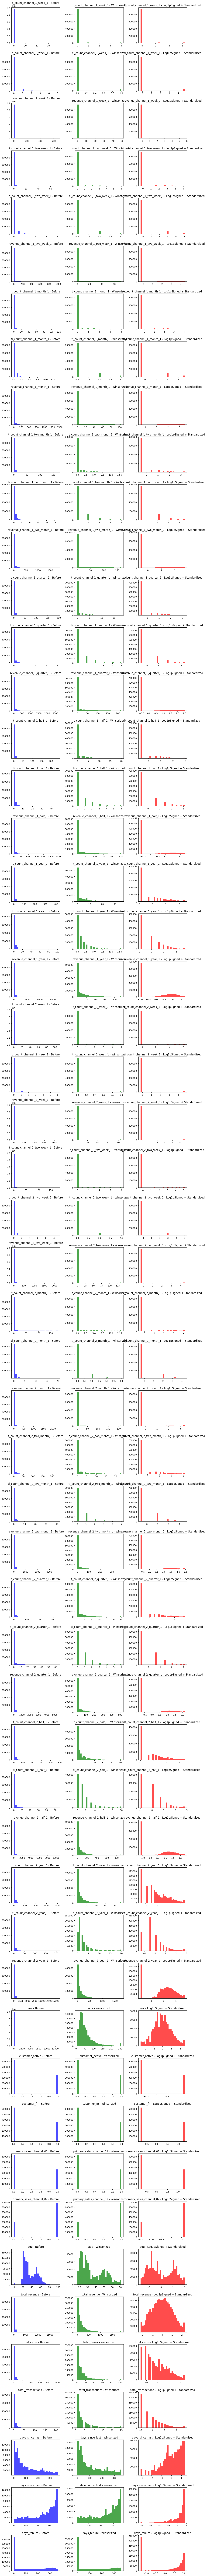

Feature,Mean (Before),Std (Before),Min (Before),Max (Before),Mean (Winsorized),Std (Winsorized),Min (Winsorized),Max (Winsorized),Mean (Log1pSigned),Std (Log1pSigned),Min (Log1pSigned),Max (Log1pSigned),Mean (Standardized),Std (Standardized),Min (Standardized),Max (Standardized)
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""t_count_channel_1_week_1""",0.126518,0.785253,0.0,38.0,0.123697,0.733697,0.0,10.0,0.052815,0.268869,0.0,2.397895,1.2328e-17,1.0,-0.196436,8.722024
"""ti_count_channel_1_week_1""",0.046529,0.229341,0.0,5.0,0.046185,0.225431,0.0,2.0,0.03104,0.148522,0.0,1.098612,-7.2225e-17,1.0,-0.208991,7.187971
"""revenue_channel_1_week_1""",1.540864,9.989343,0.0,664.15,1.496214,9.160079,0.0,124.92,0.140785,0.685653,0.0,4.835647,1.2910e-16,1.0,-0.20533,6.847284
"""t_count_channel_1_two_week_1""",0.248169,1.144291,0.0,72.0,0.244561,1.085819,0.0,13.0,0.099891,0.371241,0.0,2.639057,2.7315e-18,1.0,-0.269075,6.839675
"""ti_count_channel_1_two_week_1""",0.091198,0.338413,0.0,8.0,0.090729,0.333165,0.0,3.0,0.059074,0.207786,0.0,1.386294,-5.5207e-18,1.0,-0.284302,6.387445
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""total_items""",15.108492,21.975343,1.0,1022.0,15.041169,21.097702,1.0,213.0,2.230441,1.013353,0.693147,5.365976,1.0577e-15,1.0,-1.517037,3.094217
"""total_transactions""",4.38166,5.358699,1.0,209.0,4.365803,5.16568,1.0,49.0,1.394989,0.697922,0.693147,3.912023,7.4631e-17,1.0,-1.005617,3.60647
"""days_since_last""",110.503219,101.23689,0.0,364.0,110.503219,101.23689,0.0,364.0,4.100261,1.32516,0.0,5.899897,1.3569e-15,1.0,-3.094163,1.358053


In [53]:
fr = FeatureReport()
fr.generate_report(aligned_df, num_cols=preprocessor.num_cols)

In [54]:
#preprocessor.pipeline["cat"]

preprocessor.pipeline.named_transformers_["cat"].get_feature_names_out(['customer_fashion_news_frequency'])

array(['customer_fashion_news_frequency_Empty',
       'customer_fashion_news_frequency_Monthly',
       'customer_fashion_news_frequency_NONE',
       'customer_fashion_news_frequency_None',
       'customer_fashion_news_frequency_Regularly'], dtype=object)

In [55]:


# Get numerical feature names (they remain unchanged)
num_feature_names = preprocessor.num_cols

# Get categorical feature names (one-hot encoded)
cat_feature_names = preprocessor.pipeline.named_transformers_["cat"].get_feature_names_out(preprocessor.cat_cols)

# Combine both
all_feature_names = list(num_feature_names) + list(cat_feature_names)

print(all_feature_names)

['t_count_channel_1_week_1', 'ti_count_channel_1_week_1', 'revenue_channel_1_week_1', 't_count_channel_1_two_week_1', 'ti_count_channel_1_two_week_1', 'revenue_channel_1_two_week_1', 't_count_channel_1_month_1', 'ti_count_channel_1_month_1', 'revenue_channel_1_month_1', 't_count_channel_1_two_month_1', 'ti_count_channel_1_two_month_1', 'revenue_channel_1_two_month_1', 't_count_channel_1_quarter_1', 'ti_count_channel_1_quarter_1', 'revenue_channel_1_quarter_1', 't_count_channel_1_half_1', 'ti_count_channel_1_half_1', 'revenue_channel_1_half_1', 't_count_channel_1_year_1', 'ti_count_channel_1_year_1', 'revenue_channel_1_year_1', 't_count_channel_2_week_1', 'ti_count_channel_2_week_1', 'revenue_channel_2_week_1', 't_count_channel_2_two_week_1', 'ti_count_channel_2_two_week_1', 'revenue_channel_2_two_week_1', 't_count_channel_2_month_1', 'ti_count_channel_2_month_1', 'revenue_channel_2_month_1', 't_count_channel_2_two_month_1', 'ti_count_channel_2_two_month_1', 'revenue_channel_2_two_month

In [130]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# smote = SMOTE(random_state=42)  # Initialize SMOTE
# X_train_balanced, y_train_balanced = smote.fit_resample(X_train_standardized, y_train)
#
# # Initialize RandomUnderSampler for under-sampling
# undersampler = RandomUnderSampler(random_state=42)
# X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train_standardized, y_train)
#
#
# print(X_train_standardized.shape)
# print(X_train_balanced.shape)
# print(y_train_balanced.shape)

In [56]:
# training - cut and paste for now

import polars as pl

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
#from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

#model = LogisticRegression()
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)


model.fit(X_train_transformed, y_train)

# # Compute AUC for training set
y_train_prob = model.predict_proba(X_train_transformed)[:, 1]  # Probabilities for the positive class
train_auc = roc_auc_score(y_train, y_train_prob)
#
print(train_auc)







0.7833296611230721


Computing optimal Threshold: 0.26
Computing predictions...
AUC: 0.783
Optimal Threshold: 0.26
Maximum F1 Score: 0.52
              precision    recall  f1-score   support

           0       0.89      0.78      0.83    699411
           1       0.43      0.64      0.52    185561

    accuracy                           0.75    884972
   macro avg       0.66      0.71      0.67    884972
weighted avg       0.79      0.75      0.76    884972



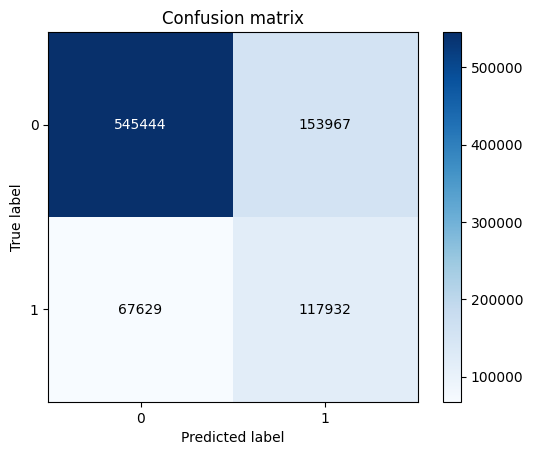

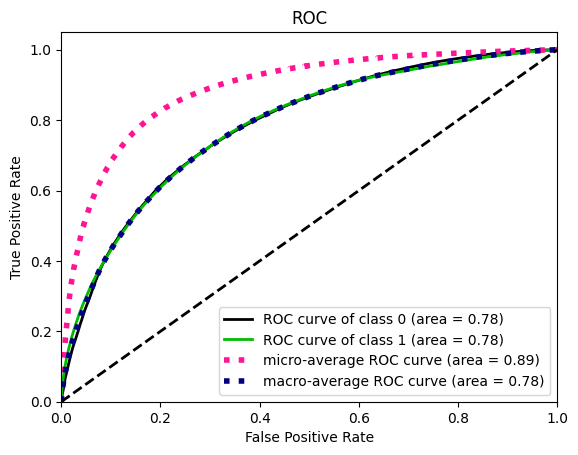

In [58]:
e_train = Evaluator(y_train, y_train_prob)
e_train.display_results()

In [59]:
# score the test


y_test_prob_both = model.predict_proba(X_test_transformed)
y_test_prob = y_test_prob_both[:, 1]  # Probabilities for the positive class

Computing optimal Threshold: 0.25
Computing predictions...
AUC: 0.780
Optimal Threshold: 0.25
Maximum F1 Score: 0.51
              precision    recall  f1-score   support

           0       0.89      0.76      0.82     77713
           1       0.42      0.65      0.51     20618

    accuracy                           0.74     98331
   macro avg       0.66      0.71      0.67     98331
weighted avg       0.79      0.74      0.76     98331



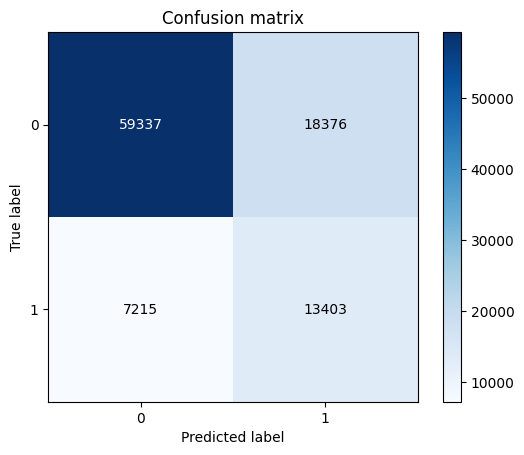

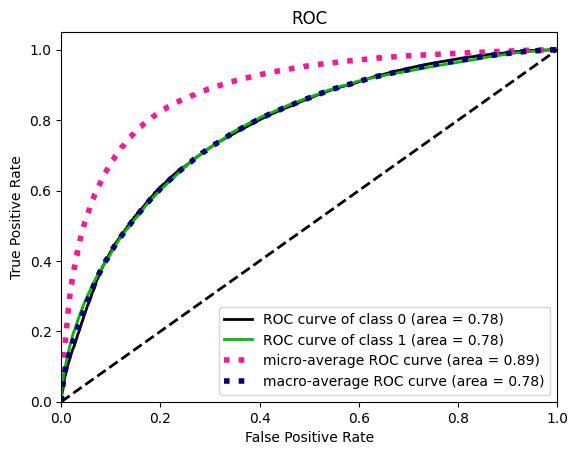

In [60]:
e_test = Evaluator(y_test, y_test_prob_both)
e_test.display_results()



In [61]:


from dataclasses import dataclass
from datetime import date

@dataclass(frozen=True)
class BTQueryConstants:
    end_date: date = date(2020, 9, 22)
    feature_duration: int = 365
    response_duration: int = 28
    additional_offset: int = 0

backtest_constants = BTQueryConstants()

# todo this is where dataset.run_query(query) would be good.  Returns DF.
# arrow_table = dataset.duckdb_conn.execute(backtest_feature_query).fetch_arrow_table()
features = Features(backtest_constants)

#backtest_response_df  = features.get_response_label(dataset.duckdb_conn)
#sql_str, backtest_feature_df = features.get_time_sliced_overlap(dataset.duckdb_conn)
#backtest_feature_df = features.get_customer_features(dataset.duckdb_conn)
backtest_feature_df  = features.get_all_features_and_response(dataset.duckdb_conn)
# todo: I do not use this view
# dataset.duckdb_conn.register("backtest_features", backtest_feature_df)

X_backtest = preprocessor.transform(backtest_feature_df)
y_backtest = backtest_feature_df["label"].to_numpy()

scores_prob_positive = model.predict_proba(X_backtest)[:, 1]
backtest_pred = [1 if prob >= e_test.optimal_threshold else 0 for prob in scores_prob_positive]

scores_df = pl.DataFrame({
    "customer_id": backtest_feature_df["customer_id"],
    "score": scores_prob_positive,
    "prediction": backtest_pred
})










FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Computing predictions...
AUC: 0.779
Optimal Threshold: 0.25
Maximum F1 Score: 0.51
              precision    recall  f1-score   support

           0       0.89      0.76      0.82    783633
           1       0.41      0.65      0.51    202402

    accuracy                           0.74    986035
   macro avg       0.65      0.71      0.66    986035
weighted avg       0.80      0.74      0.76    986035



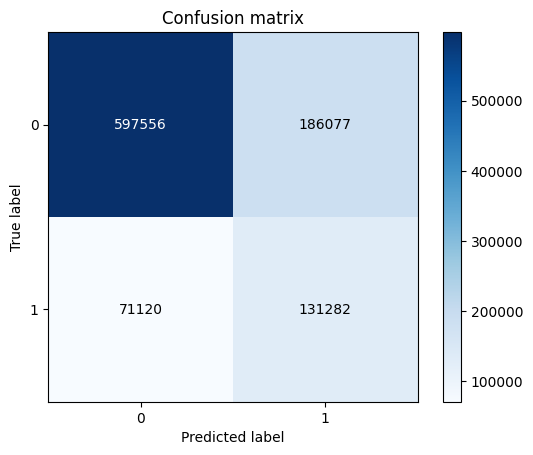

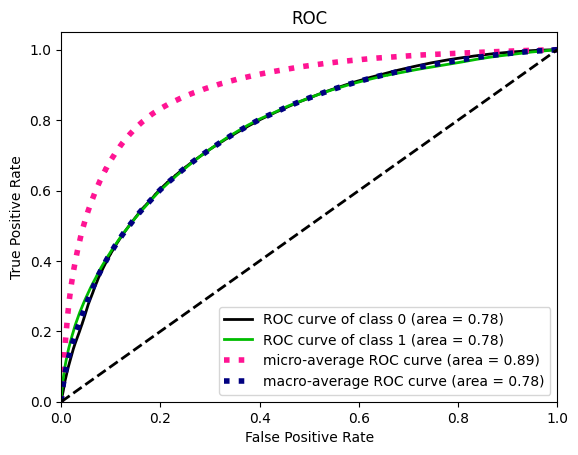

In [62]:
backtest_pred_truth_df = scores_df.join(backtest_feature_df[["label","customer_id"]], on="customer_id")
dataset.duckdb_conn.register("scores", backtest_pred_truth_df)

backtest_response = np.array(backtest_pred_truth_df["label"])
backtest_score = np.array(backtest_pred_truth_df["score"])

e_backtest = Evaluator(backtest_response, backtest_score, threshold=e_test.optimal_threshold)

e_backtest.display_results()


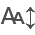

decile,buyer_count,scored_customer_count,non_buyer_count
i64,"decimal[38,0]",i64,"decimal[38,0]"
10,3727,98603,94876
9,5643,98603,92960
8,6173,98603,92430
7,9220,98603,89383
6,12707,98603,85896
5,16858,98604,81746
4,22017,98604,76587
3,28463,98604,70141
2,37883,98604,60721


In [63]:
# todo this is where I want to encapsulate the display of response curve ??? or do I care
# the display can be encapsulated ... but perhaps the computatiopn of DF still stays
# in notebook for now

# query = ''''
#
# SELECT decile, SUM(bought) buyer_count, COUNT(1) scored_customer_count, COUNT(1) - SUM(bought) non_buyer_count
# FROM (
#     SELECT s.customer_id, ntile(10) OVER (ORDER BY score desc) AS decile, COALESCE(bought,0) as bought
#     from scores s
#     left outer join (
#         SELECT customer_id, COUNT(distinct t.customer_id) bought
#         from transactions t
#         WHERE t_dat > DATE '{feature_end}'
#         GROUP BY customer_id
#     ) t on t.customer_id = s.customer_id
#     GROUP BY s.customer_id, score, bought
# ) x
# GROUP BY decile
# ORDER BY decile DESC
# '''.format(feature_end=BTQueryConstants.feature_end)

query = '''
    SELECT decile, SUM(bought) buyer_count, COUNT(1) scored_customer_count, COUNT(1) - SUM(bought) non_buyer_count
    FROM (
        SELECT s.customer_id, ntile(10) OVER (ORDER BY score desc) AS decile, label as bought
        from scores s
        GROUP BY s.customer_id, score, label
    ) x
    GROUP BY decile
    ORDER BY decile DESC

'''

backtest_results = dataset.run_query_display_results(query)
# backtest - use the new features and labels code I think firstly
# scoring ... leave this open for now

# I can use the feature query constant and set the correct parameters to get the backtest features

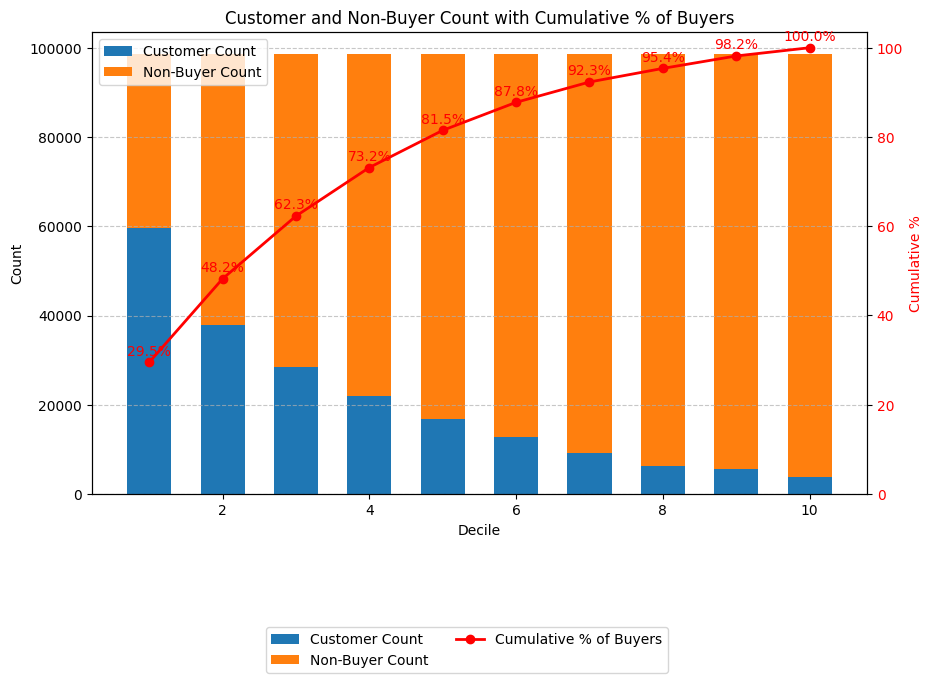

In [64]:


# plot the response curve ... put into a class
import matplotlib.pyplot as plt

# Assuming data is already created
data = backtest_results.to_pandas()

# Sort the DataFrame by decile in ascending order
data = data.sort_values(by="decile", ascending=True)

data["cumulative_percent"] = (data["buyer_count"].cumsum() / data["buyer_count"].sum() * 100)

# Extract columns as lists
decile = data["decile"].to_list()
customer_count = data["buyer_count"].to_list()
non_buyer_count = data["non_buyer_count"].to_list()
cumulative_percent = data["cumulative_percent"].to_list()

# print(cumulative_percent)
# print(customer_count)

# Create the figure and primary y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax1.bar(decile, customer_count, label="Customer Count", width=0.6)
ax1.bar(decile, non_buyer_count, bottom=customer_count, label="Non-Buyer Count", width=0.6)

# Label for the primary y-axis
ax1.set_xlabel('Decile')
ax1.set_ylabel('Count')
ax1.set_title('Customer and Non-Buyer Count with Cumulative % of Buyers')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc="upper left")

# Create a secondary y-axis for cumulative percent
ax2 = ax1.twinx()
ax2.plot(decile, cumulative_percent, color="red", marker="o", label="Cumulative % of Buyers", linewidth=2)
ax2.set_ylabel('Cumulative %', color='red')
ax2.tick_params(axis='y', labelcolor='red')

for x, y in zip(decile, cumulative_percent):
    ax2.annotate(f"{y:.1f}%", (x, y), textcoords="offset points", xytext=(0, 5), ha='center', color="red")

# Set the secondary y-axis to start at 0
ax2.set_ylim(0, ax2.get_ylim()[1])  # Start from 0, keep the max limit as it is


# Combine legends from both axes
fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2)

# Show the plot
plt.show()

# this is not yet how I want it to look but will need to do for the time being

In [65]:
# Get numerical feature names (they remain unchanged)
num_feature_names = preprocessor.num_cols

# Get categorical feature names (one-hot encoded)
cat_feature_names = preprocessor.pipeline.named_transformers_["cat"].get_feature_names_out(preprocessor.cat_cols)

# Combine both
all_feature_names = list(num_feature_names) + list(cat_feature_names)

print(all_feature_names)

print(len(all_feature_names))

print(model.feature_importances_)
print(len(model.feature_importances_))

['t_count_channel_1_week_1', 'ti_count_channel_1_week_1', 'revenue_channel_1_week_1', 't_count_channel_1_two_week_1', 'ti_count_channel_1_two_week_1', 'revenue_channel_1_two_week_1', 't_count_channel_1_month_1', 'ti_count_channel_1_month_1', 'revenue_channel_1_month_1', 't_count_channel_1_two_month_1', 'ti_count_channel_1_two_month_1', 'revenue_channel_1_two_month_1', 't_count_channel_1_quarter_1', 'ti_count_channel_1_quarter_1', 'revenue_channel_1_quarter_1', 't_count_channel_1_half_1', 'ti_count_channel_1_half_1', 'revenue_channel_1_half_1', 't_count_channel_1_year_1', 'ti_count_channel_1_year_1', 'revenue_channel_1_year_1', 't_count_channel_2_week_1', 'ti_count_channel_2_week_1', 'revenue_channel_2_week_1', 't_count_channel_2_two_week_1', 'ti_count_channel_2_two_week_1', 'revenue_channel_2_two_week_1', 't_count_channel_2_month_1', 'ti_count_channel_2_month_1', 'revenue_channel_2_month_1', 't_count_channel_2_two_month_1', 'ti_count_channel_2_two_month_1', 'revenue_channel_2_two_month

In [75]:
print(all_feature_names[3])

t_count_channel_1_two_week_1


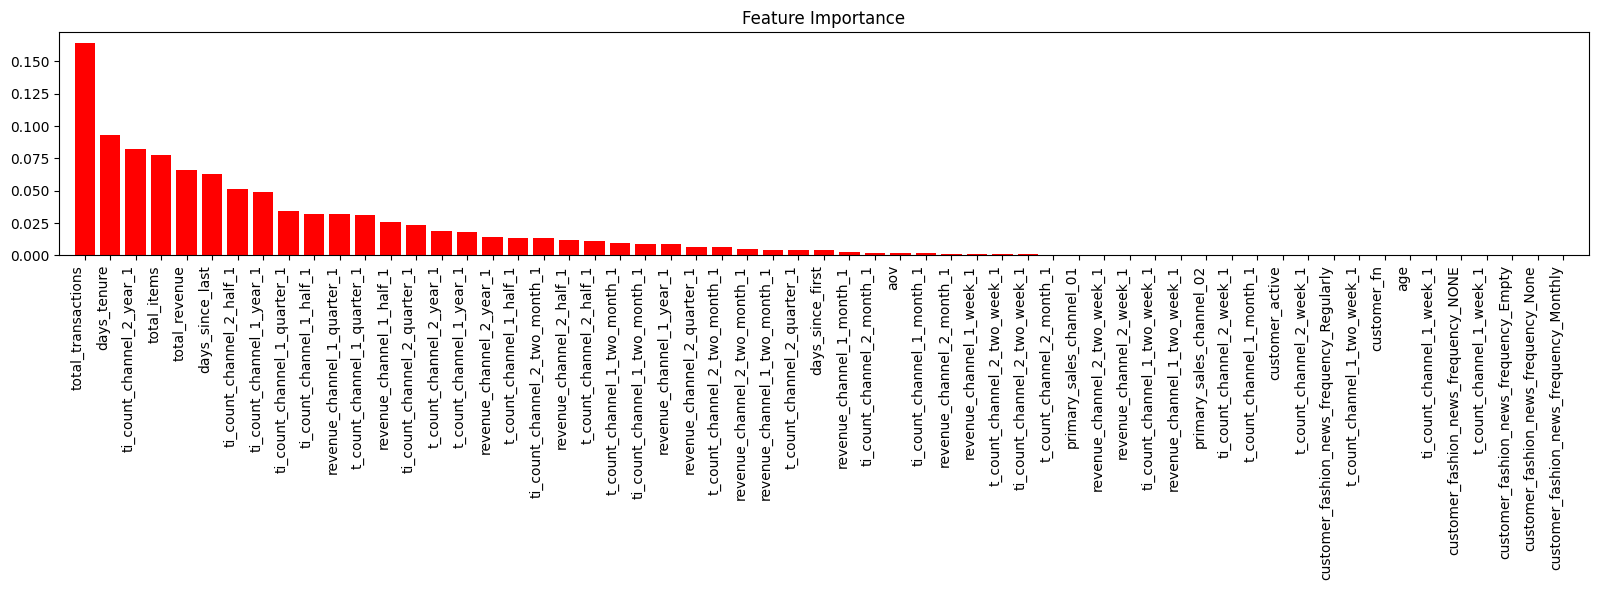

In [66]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Feature Importance
if isinstance(model, LogisticRegression):
    importance = model.coef_[0]
elif isinstance(model, RandomForestClassifier):
    importance = model.feature_importances_

indices = np.argsort(importance)[::-1]

number_of_features = len(all_feature_names)

#TODO: need to swap numbers from X to importance

# Create the plot with more space for labels
plt.figure(figsize=(16, 6))  # Adjust the width (12) and height (6) as needed
plt.title("Feature Importance")
plt.bar(range(number_of_features), importance[indices], color="r", align="center")
plt.xticks(range(number_of_features), [all_feature_names[i] for i in indices], rotation=90, ha='right')  # Rotate labels
plt.xlim([-1, number_of_features])
plt.tight_layout()  # Automatically adjust subplot parameters to give space for labels
plt.show()